# **POLARIN's ERDDAP datasets distribution in time and space**

*What is the coverage of Polarin's datasets?*

The purpose of this notebook is to show the geographical and temporal activty of the datasets available in https://erddap.s4polarin.eu/erddap/.

## Libraries and general setup

In this section we import all the Python libraries required for the analysis and visualization.

The notebook relies on:
- **requests** to query the ERDDAP REST API and retrieve dataset metadata,
- **collections.Counter** to summarize dataset activity over time,
- **matplotlib** and **cartopy** to produce geographic and temporal visualizations,
- **numpy** for basic numerical handling.

Warnings are explicitly suppressed to keep the notebook output clean and focused on the results

In [ ]:
!pip install cartopy matplotlib

In [13]:
from collections import Counter
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import numpy as np
import random
import requests
import warnings

warnings.filterwarnings("ignore")

## Retrieving the list of available datasets

We start by querying the ERDDAP `allDatasets` endpoint, which provides a machine-readable catalogue of all datasets published by the server.

From this response, we:
- extract the dataset identifiers,
- keep only datasets that are publicly accessible,
- remove the `allDatasets` entry itself, which is a special internal ERDDAP dataset.

The resulting list represents the full set of datasets that will be analysed in the remainder of the notebook.


In [14]:
all_datasets_url = "https://erddap.s4polarin.eu/erddap-cnr/erddap/tabledap/allDatasets.json"

all_datasets_resp = requests.get(all_datasets_url)
all_datasets_resp = all_datasets_resp.json()
all_datasets = [r[0] for r in all_datasets_resp['table']['rows'] if r[20]]
all_datasets.remove('allDatasets')

## Extracting temporal coverage for each dataset

For each dataset, we query its metadata using the ERDDAP `info` endpoint.
From this metadata we extract:
- the **start time** (`time_coverage_start`),
- the **end time** (`time_coverage_end`).

A helper function is used to scan the metadata table and retrieve these values when available.
Datasets for which temporal information cannot be retrieved are skipped, ensuring that only valid time ranges are used in the analysis.

In [4]:
base_meta_url_template = "https://erddap.s4polarin.eu/erddap-cnr/erddap/info/[dataset_id]/index.json"
all_times = {}

def get_min_max_time(dataset_resp):
  rows = dataset_resp.json()["table"]["rows"]
  min_t = None
  max_t = None
  for row in rows:
    if row[2] == 'time_coverage_start':
      min_t = row[-1]
    if row[2] == 'time_coverage_end':
      max_t = row[-1]
  return min_t, max_t

for dataset_id in all_datasets:
  try:
    meta_resp = requests.get(base_meta_url_template.replace('[dataset_id]', dataset_id))
    meta_resp.raise_for_status()
    min_time, max_time = get_min_max_time(meta_resp)
    all_times[dataset_id] = [min_time, max_time]
  except Exception as e:
    print(f"Error getting metadata for {dataset_id}. It will be skipped...")

if all_times:
  all_years = []
  for idx, t in all_times.items():
    if None in t:
      continue
    min_year = int(t[0][:4])
    max_year = int(t[1][:4])
    all_years.append([i for i in range(min_year, max_year + 1)])
else:
  print(f"Couldn't get minimum and maximum times for any of the datasets")

if all_years:
  counted_years = Counter([x for xs in all_years for x in xs])

## Dataset activity over time

The final step in this section is a bar plot showing the number of active datasets per year.

This visualization highlights:
- periods of increased data production,
- long-term dataset continuity,
- potential gaps or growth phases in the POLARIN data archive.

Each bar represents the number of datasets that include observations for the corresponding year.

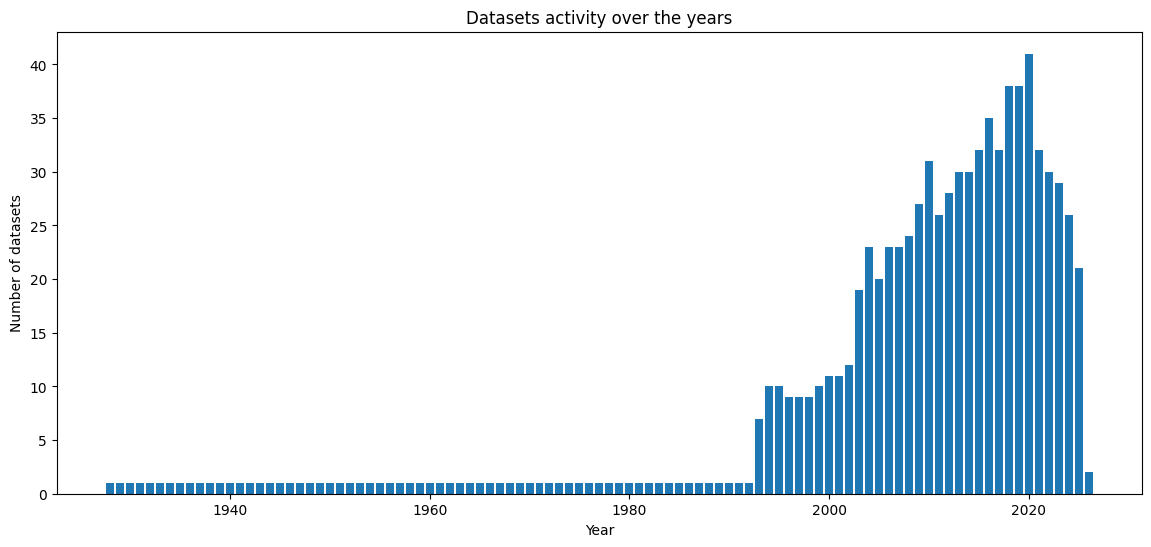

In [8]:
plt.figure(figsize=(14, 6))
plt.bar(counted_years.keys(), counted_years.values())
plt.title("Datasets activity over the years")
plt.ylabel("Number of datasets")
plt.xlabel("Year")
plt.show()

## Retrieving spatial coordinates for each dataset

In this section we retrieve the geographical coordinates associated with each dataset; **this step may take several minutes (approximately 5-10 minutes) to complete due to the large number of individual requests sent to the ERDDAP server**.

For every dataset identifier, we query the ERDDAP `tabledap` service to extract:
- latitude
- longitude

Only these two variables are requested to minimize the size of the response.
Datasets that do not expose geographic coordinates or return an error are safely skipped.


In [9]:
def get_coords(dataset_id):
  try:
    unique_coords_url = f"https://erddap.s4polarin.eu/erddap-cnr/erddap/tabledap/{dataset_id}.json?latitude%2Clongitude"
    coords_resp = requests.get(unique_coords_url)
    if coords_resp.status_code in [400, 404]:
      return
    coords_resp.raise_for_status()
    coords_values = coords_resp.json()["table"]["rows"]
    return coords_values
  except Exception as e:
    print(f"Something went wrong while getting coordinates for {dataset_id}: {str(e)}")

all_coords = {}
for dataset_id in all_datasets:
  all_coords[dataset_id] = get_coords(dataset_id)

## Spatial distribution of datasets across global and polar projections

In this section, the spatial coverage of all datasets is visualized using three complementary map projections:
- a **global Mercator projection** for an overall view,
- a **North Polar Stereographic projection** to emphasize Arctic coverage,
- a **South Polar Stereographic projection** to emphasize Antarctic coverage.

Before plotting, the downloaded coordinates are cleaned to remove missing values and organized into NumPy arrays for efficient rendering.
Each dataset is assigned a distinct color to allow visual separation across all maps.

Although individual points are plotted, the resulting patterns often reveal **platform trajectories**, providing insight into the spatial sampling behaviour of the observing systems.
To improve performance and reduce memory usage, the scatter points are rasterized while coastlines remain vector-based.

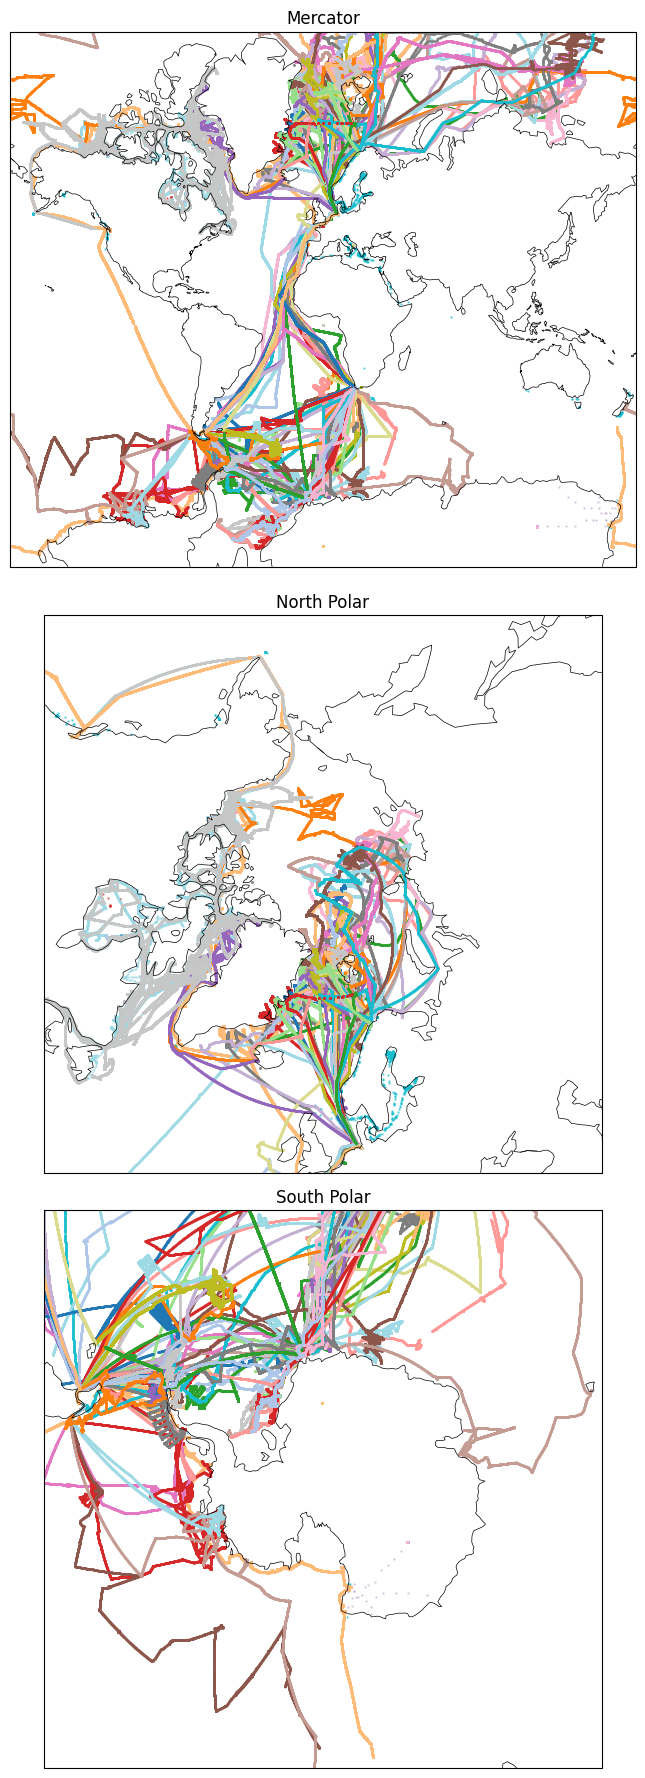

In [12]:
datasets_arrays = {}
for dataset, coords in all_coords.items():
    if not coords:
        continue
    arr = np.array(
        [(lat, lon) for lat, lon in coords if lat is not None and lon is not None],
        dtype=float
    )
    if len(arr) == 0:
        continue
    datasets_arrays[dataset] = {
        "lats": arr[:, 0],
        "lons": arr[:, 1]
    }

cmap = matplotlib.colormaps["tab20"]
datasets_colors = {

    p: cmap(i % cmap.N)
    for i, p in enumerate(datasets_arrays)
}

fig = plt.figure(figsize=(8, 18))

projections = [
    ("Mercator", ccrs.Mercator()),
    ("North Polar", ccrs.NorthPolarStereo()),
    ("South Polar", ccrs.SouthPolarStereo())
]

for i, (title, proj) in enumerate(projections, 1):
    ax = fig.add_subplot(3, 1, i, projection=proj)
    ax.coastlines(linewidth=0.5)
    ax.set_title(title)

    if "Polar" in title:
        ax.set_extent(
            [-180, 180,
             50 if "North" in title else -90,
             90 if "North" in title else -50],
            ccrs.PlateCarree()
        )
    else:
        ax.set_global()

    for platform, data in datasets_arrays.items():
        ax.scatter(
            data["lons"],
            data["lats"],
            s=0.5,
            color=datasets_colors[platform],
            alpha=0.6,
            transform=ccrs.PlateCarree(),
            rasterized=True
        )

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

The Python libraries that have been used in this notebook are:
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)      
- [requests](https://requests.readthedocs.io/en/latest/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)

This work has received funding from the European Union Horizon Europe project Polar Research Infrastructure Network (POLARIN) under grant agreement No. 101130949 (https://doi.org/10.3030/101130949).
This notebook makes use of data available in the European Marine Observation and Data Network (EMODnet, https://emodnet.ec.europa.eu).

<center>
  <div style="display: flex; justify-content: center; align-items: flex-start; gap: 20px;">
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/TO-USE-RGB-for-digital-materials-V.png" height="120" style="margin-top: 50px;"/>
    <img src="https://eu-polarin.eu/wp-content/uploads/2024/04/polarin-web1.svg" height="100"/>
    <img src="https://emodnet.ec.europa.eu/sites/emodnet.ec.europa.eu/files/public/emodnet_logos/web/EMODnet_standard_colour.png" height="100"/>
  </div>
</center>